In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style(style="whitegrid")

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.model_selection import validation_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier

SEED = 1

In [5]:
def plot_validation_curve(train_scores, cv_scores, x_data, y_label='', x_label='', x_logscale=False, ylim=[0,1.1], title='Validation Curve', ax=None):    
    """ 
    Plot a validation curve using train_scores and cv_scores.
    
    Args:
        cm         this must be a sklearn confusion matrix 
        classes    levels of the class being predicted; default to binary outcome
        normalize  apply normalization by setting `normalize=True`
        title      title for the plot
        cmap       color map
    """
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    cv_scores_mean = np.mean(cv_scores, axis=1)
    cv_scores_std = np.std(cv_scores, axis=1)

    lw = 2
    
    if ax == None: 
        plt.title(title)
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.ylim(ylim)
        if x_logscale:
            plt.semilogx(x_data, train_scores_mean, 'o-', label="Training score", color="darkorange", lw=lw)
        else:
            plt.plot(x_data, train_scores_mean, 'o-', label="Training score", color="darkorange", lw=lw)

        plt.fill_between(x_data, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color="darkorange", lw=lw)

        if x_logscale:
            plt.semilogx(x_data, cv_scores_mean, 'o-', label="Cross-validation score", color="navy", lw=lw)
        else:
            plt.plot(x_data, cv_scores_mean, 'o-', label="Cross-validation score", color="navy", lw=lw)

        plt.fill_between(x_data, cv_scores_mean - cv_scores_std, cv_scores_mean + cv_scores_std, alpha=0.2, color="navy", lw=lw)
        plt.legend(loc='best')
    else:
        ax.set_title(title)
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        ax.set_ylim(ylim)
        if x_logscale:
            ax.semilogx(x_data, train_scores_mean, 'o-', label="Training score", color="darkorange", lw=lw)
        else:
            ax.plot(x_data, train_scores_mean, 'o-', label="Training score", color="darkorange", lw=lw)

        ax.fill_between(x_data, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color="darkorange", lw=lw)

        if x_logscale:
            ax.semilogx(x_data, cv_scores_mean, 'o-', label="Cross-validation score", color="navy", lw=lw)
        else:
            ax.plot(x_data, cv_scores_mean, 'o-', label="Cross-validation score", color="navy", lw=lw)

        ax.fill_between(x_data, cv_scores_mean - cv_scores_std, cv_scores_mean + cv_scores_std, alpha=0.2, color="navy", lw=lw)
        ax.legend(loc="best")

In [7]:
def plot_confusion_matrix(cm, title='Confusion Matrix', ax=None):
    """ 
    Function to plot a sklearn confusion matrix, showing number of cases per prediction condition. 
    The cm parameter can be an object created by the sklearn confusion_matrix() function.
    
    Input:
        cm         sklearn confusion matrix 
        title      title of the plot
        ax         ax of the plot if given
    """
    sns.heatmap(data=pd.DataFrame(cm), vmin=0, annot=True, square=True, cmap=plt.cm.Reds, fmt='g', ax=ax)
    if ax == None:
        plt.xlabel('Predicted label')
        plt.ylabel('True label')
        plt.title(title)
    else:
        ax.set_xlabel('Predicted label')
        ax.set_ylabel('True label')
        ax.set_title(title)

# Load data

In [8]:
df_well_being_raw = pd.read_excel("data/london-ward-well-being-probability-scores.xls", sheet_name="Dashboard", skiprows=12)
df_grocery_raw = pd.read_csv('data/year_osward_grocery.csv')

In [10]:
df_well_being_raw.head(2)

,Borough name,Ward Code,Ward name,Unnamed: 3,Unnamed: 4,2009,2010,2011,2012,2013,Unnamed: 10,Unnamed: 11,See full data set (e.g. numbers/rates),Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19
0,City of London,E09000001,City of London,NaN,NaN,3.868138,2.584469,2.159794,1.046416,1.420837,NaN,-0.611825,NaN,NaN,NaN,-1.283670,-0.424675,-1.113377,0.374420,-0.611825
1,Barking and Dagenham,E05000026,Abbey,NaN,NaN,3.695918,3.854677,2.949578,1.542211,0.699065,NaN,-0.749213,NaN,NaN,NaN,0.158758,-0.905099,-1.407367,-0.843146,NaN


We chose to keep only the well being for the year 2013. The criteria to compute the well being are life expectancy, childhood obesity and happiness. As stated in the dataframe, "[well-being] scores over 0 indicate a higher probability that the population on average experiences positive well-being according to these measures."

In [11]:
df_well = df_well_being_raw[["Ward Code", 2013]]
df_well.columns = ['area_id', 'well_being']
df_well = df_well.drop(0)
df_well = df_well.dropna()

In [12]:
df_well.head(2)

,area_id,well_being
1,E05000026,0.699065
2,E05000027,-8.902220


In [13]:
# Select the columns of interest in the grocery DataFrame

df_grocery = df_grocery_raw[["area_id", "fat", "saturate", "salt", "sugar", "protein", "carb", "fibre", "alcohol", "energy_fat", "energy_saturate","energy_sugar", 
                             "energy_protein", "energy_carb", "energy_fibre", "energy_alcohol", "energy_tot", "h_nutrients_calories_norm",
                            'f_beer', 'f_dairy', 'f_eggs', 'f_fats_oils', 'f_fish', 'f_fruit_veg', 'f_grains', 'f_meat_red', 'f_poultry',
                             'f_readymade', 'f_sauces', 'f_soft_drinks', 'f_spirits', 'f_sweets', 'f_tea_coffee', 'f_water', 'f_wine']]

# Compute the percentage of energy of nutrients
nutrients = ["fat", "protein", "carb", "fibre", "alcohol"]
df_grocery_percentage = df_grocery.copy()
for i, nutrient in enumerate (nutrients):
    df_grocery_percentage["percentage_%s"%nutrient] = df_grocery_percentage["energy_%s"%nutrient] *100 / df_grocery["energy_tot"]

In [14]:
df_grocery_percentage.head(2)

,area_id,fat,saturate,salt,sugar,protein,carb,fibre,alcohol,energy_fat,...,f_spirits,f_sweets,f_tea_coffee,f_water,f_wine,percentage_fat,percentage_protein,percentage_carb,percentage_fibre,percentage_alcohol
0,E05000026,9.488797,3.693721,0.583240,10.966213,4.977560,19.381951,1.564721,0.198172,85.399176,...,0.004656,0.181254,0.005945,0.042942,0.007917,45.640000,10.640657,41.433292,1.544686,0.741364
1,E05000027,9.733634,3.565913,0.568184,10.514427,5.211694,18.950348,1.581960,0.209917,87.602703,...,0.005180,0.173620,0.005572,0.041258,0.007355,46.439549,11.051200,40.183491,1.546797,0.778963


In [15]:
# Merge the grocery DataFrame witht the well-being one
df = df_well.merge(df_grocery_percentage, on='area_id')

In [16]:
df.head(2)

,area_id,well_being,fat,saturate,salt,sugar,protein,carb,fibre,alcohol,...,f_spirits,f_sweets,f_tea_coffee,f_water,f_wine,percentage_fat,percentage_protein,percentage_carb,percentage_fibre,percentage_alcohol
0,E05000026,0.699065,9.488797,3.693721,0.583240,10.966213,4.977560,19.381951,1.564721,0.198172,...,0.004656,0.181254,0.005945,0.042942,0.007917,45.640000,10.640657,41.433292,1.544686,0.741364
1,E05000027,-8.902220,9.733634,3.565913,0.568184,10.514427,5.211694,18.950348,1.581960,0.209917,...,0.005180,0.173620,0.005572,0.041258,0.007355,46.439549,11.051200,40.183491,1.546797,0.778963


# Spearman rank correlation

We decided to perform a Spearman correlation between:
 - the percentage of nutrients and the well-being
 - the weight of the nutrients and the well-being
 - the energy for each nutrient and the well-being
 - the entropy of nutrients and the well-being

In [50]:
spearman_nutrients = {}
spearman_nutrients_plot = {}
spearman_weight = {}
spearman_weight_plot = {}
spearman_energy = {}
spearman_energy_plot = {}

for nutrient in nutrients:
    spearman_nutrients[nutrient] = stats.spearmanr(df["percentage_%s"%nutrient],df['well_being'])
    spearman_nutrients_plot[nutrient] = spearman_nutrients[nutrient].correlation
    spearman_weight[nutrient] = stats.spearmanr(df["%s"%nutrient],df['well_being'])
    spearman_weight_plot[nutrient] = spearman_weight[nutrient].correlation
    spearman_energy[nutrient] = stats.spearmanr(df["energy_%s"%nutrient],df['well_being'])
    spearman_energy_plot[nutrient] = spearman_energy[nutrient].correlation
    
spearman_entropy = stats.spearmanr(df["h_nutrients_calories_norm"],df['well_being'])

In [52]:
def plot_barplot(x, y, title='Correlation', ylabel='R'):
    """
    Plots a barplot.
    """
    plt.figure(figsize=(11,5))

    sns.set_style('darkgrid')
    plt.xticks(rotation=90)
    plt.ylabel(ylabel, fontsize=20)

    plt.title(title)
    plt.tick_params(labelsize=15)
    plt.axhline(y=0, color='black')

    sns.barplot(x=x,y=y)
    plt.show()

In [60]:
spearman_entropy

SpearmanrResult(correlation=0.2484334667186093, pvalue=3.153142012313915e-08)

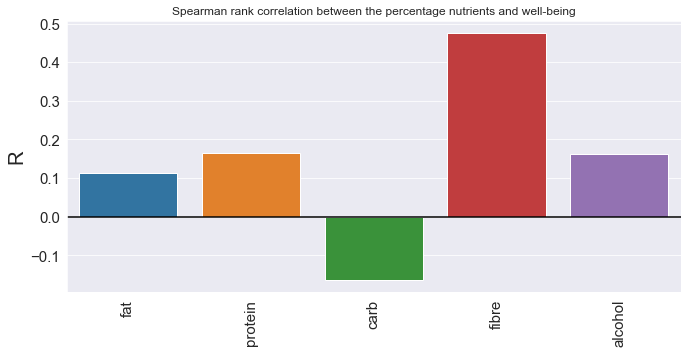

In [54]:
plot_barplot(nutrients, list(spearman_nutrients_plot.values()), 
             title="Spearman rank correlation between the percentage of nutrients and the well-being", ylabel='R')

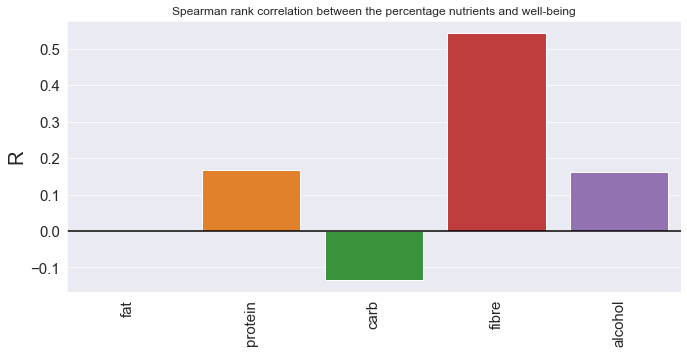

In [55]:
plot_barplot(nutrients, list(spearman_weight_plot.values()), 
             title="Spearman rank correlation between the weight of the nutrients and the well-being", ylabel='R')

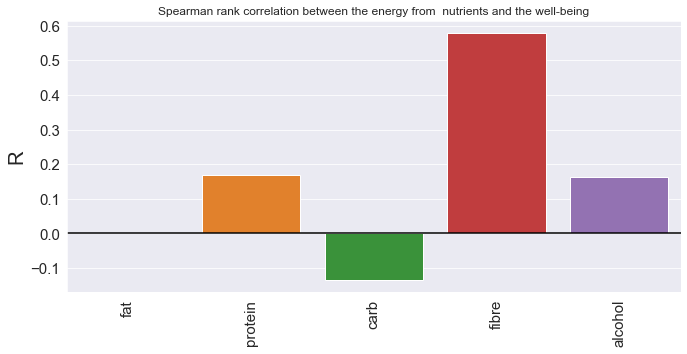

In [59]:
plot_barplot(nutrients, list(spearman_energy_plot.values()), 
             title="Spearman rank correlation between the energy from  nutrients and the well-being", ylabel='R')

In [61]:
spearman_entropy

SpearmanrResult(correlation=0.2484334667186093, pvalue=3.153142012313915e-08)

In these correlations the p-value is always lower than 0.05 except for the weight and energy of fat. We can see that the correlation of fibre with well-being is high. The correlation between the entropy of nutrients and well-being is high and with a p-value lower than 0.05.

# Linear regression model 
We tried to to fit a linear regression model to :
 - the weight of nutrients 
 - fraction of products purchased

In [62]:
# Fit linear regression model to nutrients
mod = smf.ols(formula='well_being ~  fat + sugar + alcohol + carb + saturate + protein + fibre', data=df)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:             well_being   R-squared:                       0.397
Model:                            OLS   Adj. R-squared:                  0.388
Method:                 Least Squares   F-statistic:                     44.65
Date:                Thu, 17 Dec 2020   Prob (F-statistic):           1.91e-48
Time:                        11:37:36   Log-Likelihood:                -1448.7
No. Observations:                 483   AIC:                             2913.
Df Residuals:                     475   BIC:                             2947.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -79.8253      9.492     -8.410      0.0

In [63]:
# Fit logistic regression model to foods
mod = smf.ols(formula='well_being ~  f_beer + f_dairy + f_eggs + f_fats_oils+f_fish+f_fruit_veg+f_grains+f_meat_red+f_poultry+f_readymade + f_sauces+f_soft_drinks+f_spirits+f_sweets+f_tea_coffee+f_water+f_wine', data=df)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:             well_being   R-squared:                       0.460
Model:                            OLS   Adj. R-squared:                  0.441
Method:                 Least Squares   F-statistic:                     24.80
Date:                Thu, 17 Dec 2020   Prob (F-statistic):           1.74e-52
Time:                        11:37:36   Log-Likelihood:                -1422.1
No. Observations:                 483   AIC:                             2878.
Df Residuals:                     466   BIC:                             2949.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       -50.6805     20.895     -2.426

# Healthy diet 

## Healhty score according to Wikipedia
source: https://en.wikipedia.org/wiki/Healthy_diet

We used the table of "three healthy patterns" and picked the U.S. style. We converted all quantities in daily cups and computed the percentage of each food that lead to a healthy diet according to Wikipedia.

In [66]:
foods = dict(zip(["fruit_veg", "grains", "dairy", "meat_red", "poultry", "eggs", "fish"], [4.5, 0.75, 3, 1.5/7, 1.25/7, 0.375/7, 1/7]))
sum_values = sum(foods.values())

for food in foods.keys():
    foods[food] = foods[food]/sum_values

In [67]:
# foods is a dictionnary containing the percentage of type of food recommended per day
foods

{'fruit_veg': 0.5090909090909091,
 'grains': 0.08484848484848485,
 'dairy': 0.3393939393939394,
 'meat_red': 0.024242424242424242,
 'poultry': 0.020202020202020204,
 'eggs': 0.006060606060606061,
 'fish': 0.01616161616161616}

In [68]:
# create a "score" column in the DataFrame. This column contains the sum of squared errors of the food fraction of the area 
# and the healthy food fraction.
# The higher the score, the less healthy the area eats. 
df_healthy = df.copy()
df_healthy.loc[:,"score"] =0
for food in foods:
    df_healthy["score"] += (df_healthy["f_%s"%food] - foods[food])**2
    

In [69]:
df_healthy.head(2)

,area_id,well_being,fat,saturate,salt,sugar,protein,carb,fibre,alcohol,...,f_sweets,f_tea_coffee,f_water,f_wine,percentage_fat,percentage_protein,percentage_carb,percentage_fibre,percentage_alcohol,score
0,E05000026,0.699065,9.488797,3.693721,0.583240,10.966213,4.977560,19.381951,1.564721,0.198172,...,0.181254,0.005945,0.042942,0.007917,45.640000,10.640657,41.433292,1.544686,0.741364,0.125700
1,E05000027,-8.902220,9.733634,3.565913,0.568184,10.514427,5.211694,18.950348,1.581960,0.209917,...,0.173620,0.005572,0.041258,0.007355,46.439549,11.051200,40.183491,1.546797,0.778963,0.130958


### Perform Spearman rank correlation on the healthy score and well-being

In [71]:
stats.spearmanr(df_healthy["score"],df_healthy['well_being'])

SpearmanrResult(correlation=-0.22672170628643162, pvalue=4.765268124884234e-07)

The p-value is lower than 0.05 and the correlation is negative. Does a healthy diet actually lead to a lower well-being ?

## Healthy score according to the FDA

### CAREFUL, NO LIFE EXPECTANCY!! --> ??

source: https://www.fda.gov/media/135301/download pages 4 to 6.

We used the weight of each nutrient in the table and computed a percentage of nutrients that lead to a healthy diet according to the FDA. 
The table presents "original" and "updated" values, so we computed scores according to both.

In [74]:
foods_fda_updated = dict(zip(["fat", "fibre", "carb", "protein", "saturate"], [78, 28, 275, 50, 20]))
foods_fda_old = dict(zip(["fat", "fibre", "carb", "protein", "saturate"], [65, 25, 300, 50, 20]))

#saturate is included in fat so we do not include it in the sum of nutrients
sum_values_fda_updated = sum(list(foods_fda_updated.values())[:-1])
sum_values_fda_old = sum(list(foods_fda_old.values())[:-1])

# compute percentage of nutrients for a healthy diet
for food in foods_fda_updated.keys():
    foods_fda_updated[food] = foods_fda_updated[food]/sum_values_fda_updated
    foods_fda_old[food] = foods_fda_old[food]/sum_values_fda_old

In [75]:
df_fda = df_healthy[["area_id", "well_being", "fat", "fibre", "carb", "protein", "saturate"]]

df_fda_percentage = df_fda.copy()

#2:5 --> not the saturated for the sum because they are included in fat
df_fda_percentage["weight_tot"] = df_fda.iloc[:,2:5].sum(axis=1)

#2:6 --> only for nutrients
for nutrient in df_fda_percentage.columns[2:7]:
    df_fda_percentage["percentage_%s"%nutrient] = df_fda_percentage["%s"%nutrient] / df_fda_percentage["weight_tot"]

In [77]:
df_fda_percentage.loc[:,"score_updated"] = 0
df_fda_percentage.loc[:,"score_old"] = 0

for nutrient in  df_fda_percentage.columns[2:7]:
    df_fda_percentage["score_updated"] += (df_fda_percentage["percentage_%s"%nutrient] - foods_fda_updated[nutrient])**2
    df_fda_percentage["score_updated"] = 1 - df_fda_percentage["score_updated"]
    
    df_fda_percentage["score_old"] += (df_fda_percentage["percentage_%s"%nutrient] - foods_fda_old[nutrient])**2
    df_fda_percentage["score_old"] = 1 - df_fda_percentage["score_old"]

In [79]:
df_fda_percentage.head(2)

,area_id,well_being,fat,fibre,carb,protein,saturate,weight_tot,percentage_fat,percentage_fibre,percentage_carb,percentage_protein,percentage_saturate,score_updated,score_old
0,E05000026,0.699065,9.488797,1.564721,19.381951,4.977560,3.693721,30.435469,0.311768,0.051411,0.636821,0.163545,0.121362,0.979716,0.967824
1,E05000027,-8.902220,9.733634,1.581960,18.950348,5.211694,3.565913,30.265942,0.321604,0.052269,0.626128,0.172197,0.117819,0.978299,0.964879


### Perform Spearman rank correlation between the healthy scores and well-being

In [81]:
stats.spearmanr(df_fda_percentage["score_old"],df_fda_percentage['well_being'])

SpearmanrResult(correlation=-0.13836271153444327, pvalue=0.0023065731774153087)

In [82]:
stats.spearmanr(df_fda_percentage["score_updated"],df_fda_percentage['well_being'])

SpearmanrResult(correlation=-0.12364521149557148, pvalue=0.006512619007831846)

Both p-values are lower than 0.05 and both correlations are negative. Is eating healthy bad for one's well-being ?

Plot well-being as a function of different classes. We see that there is rarely a correlation

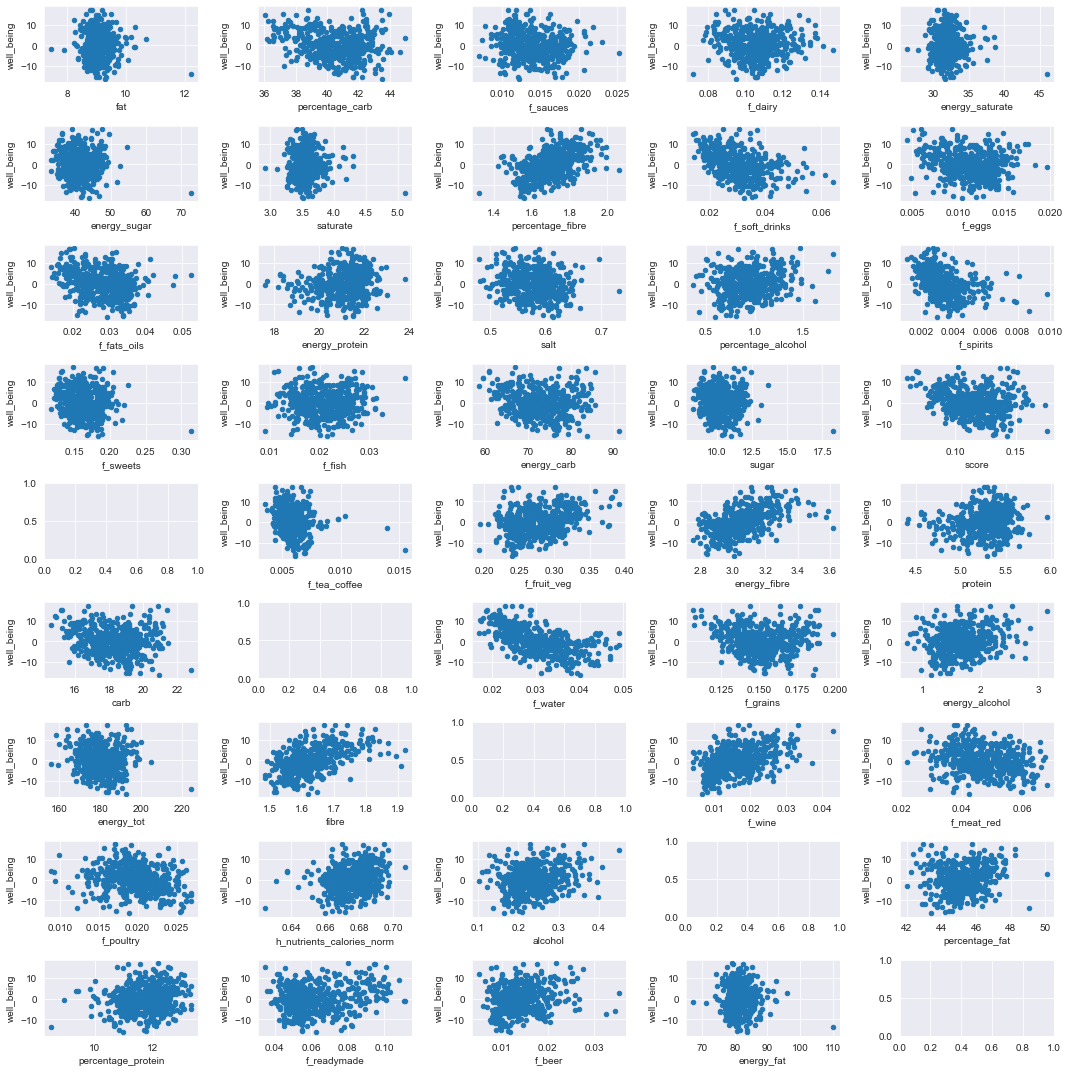

In [94]:
fig, axes = plt.subplots(nrows = 9, ncols=5, tight_layout=True, figsize=(15, 15))

for i, feature in enumerate(df_healthy_well.columns[2:-1]):
    df_healthy_well.plot(x=feature, y='well_being', kind='scatter', ax=axes[i%9][i%5])

Plot well-being as a function of the percentage and weight of the nutrients. Again, we cannot see any correlation.

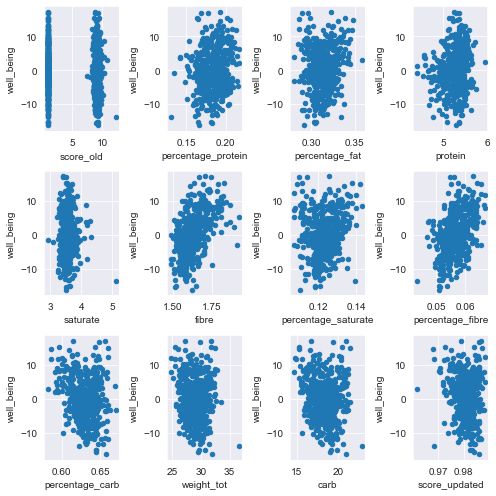

In [95]:
fig, axes = plt.subplots(nrows = 3, ncols=4, tight_layout=True, figsize=(7, 7))

for i, feature in enumerate(df_fda_wellness.columns[2:-1]):
    df_fda_wellness.plot(x=feature, y='well_being', kind='scatter', ax=axes[i%3][i%4])

# Logit regression on the well-being

Plot the distribution of the well-being. Scores over 0 indicate a higher probability that the population on average experiences positive well-being. We decided to try to transform the problem in a classification problem with two classes: happy (well-being>=0) and unhappy (well-being<0).

<AxesSubplot:>

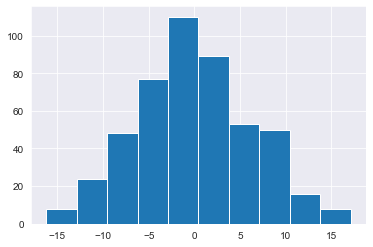

In [84]:
df_fda_percentage["well_being"].hist()

### Create 'well' variable for FDA definition 
well is zero for negative well-being and one for positive well-being.

In [100]:
# Create the column in the FDA DataFrame
df_fda_wellness = df_fda_percentage.copy()
df_fda_wellness["well"] = 0
df_fda_wellness["well"].loc[df_fda_percentage['well_being'] > 0] = 1

C:\Users\emmab\Anaconda3\envs\ada\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [101]:
df_fda_wellness.head(2)

,area_id,well_being,fat,fibre,carb,protein,saturate,weight_tot,percentage_fat,percentage_fibre,percentage_carb,percentage_protein,percentage_saturate,score_updated,score_old,well
0,E05000026,0.699065,9.488797,1.564721,19.381951,4.977560,3.693721,30.435469,0.311768,0.051411,0.636821,0.163545,0.121362,0.979716,0.967824,1
1,E05000027,-8.902220,9.733634,1.581960,18.950348,5.211694,3.565913,30.265942,0.321604,0.052269,0.626128,0.172197,0.117819,0.978299,0.964879,0


Let's plot the classes as a function of the healthy diet score. Sadly, the plot shows no clear tendency.

<AxesSubplot:xlabel='score_updated', ylabel='well'>

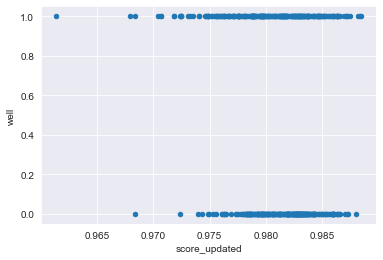

In [102]:
df_fda_wellness.plot(x='score_updated', y='well', kind='scatter')

### Create 'well' variable for Wikipedia definition 
well is zero for negative well-being and one for positive well-being.

In [97]:
# Create the column in the Wikipedia DataFrame
df_healthy_well = df_healthy.copy()
df_healthy_well["well"] = 0
df_healthy_well["well"].loc[df_healthy_well['well_being'] > 0] = 1

C:\Users\emmab\Anaconda3\envs\ada\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [103]:
df_healthy_well.head(2)

,area_id,well_being,fat,saturate,salt,sugar,protein,carb,fibre,alcohol,...,f_tea_coffee,f_water,f_wine,percentage_fat,percentage_protein,percentage_carb,percentage_fibre,percentage_alcohol,score,well
0,E05000026,0.699065,9.488797,3.693721,0.583240,10.966213,4.977560,19.381951,1.564721,0.198172,...,0.005945,0.042942,0.007917,45.640000,10.640657,41.433292,1.544686,0.741364,0.125700,1
1,E05000027,-8.902220,9.733634,3.565913,0.568184,10.514427,5.211694,18.950348,1.581960,0.209917,...,0.005572,0.041258,0.007355,46.439549,11.051200,40.183491,1.546797,0.778963,0.130958,0


Let's plot the classes as a function of the healthy diet score. Sadly, the plot shows no clear tendency.

<AxesSubplot:xlabel='score', ylabel='well'>

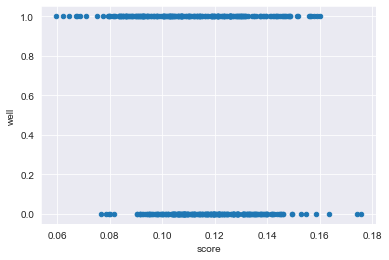

In [99]:
df_healthy_well.plot(x='score', y='well', kind='scatter')

# Classifier

We decided to train a classifier to predict the class (positive or negative well-being) for each area.

In [106]:
df_train = df_fda_wellness.sample(frac=0.7) ###ca sert a quoi ca ??

# Split into train and test
X = df_fda_wellness[["score_updated", "percentage_fat", "percentage_fibre", "percentage_carb", "percentage_protein", "percentage_saturate"]]
y = df_fda_wellness["well"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=SEED)

In [107]:
# Use a Random Forest Classifier to predict labels
N_values  = np.array([int(i) for i in np.linspace(5.0, 200, 5)])
model     = RandomForestClassifier(random_state=SEED)
cv_schema = StratifiedKFold(n_splits=3, random_state=SEED)

train_scores_val, cv_scores_val = validation_curve(model, X_train, y_train,
                                                   scoring='accuracy',
                                                   param_name = "n_estimators", 
                                                   param_range = N_values,
                                                   cv=cv_schema)

C:\Users\emmab\Anaconda3\envs\ada\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


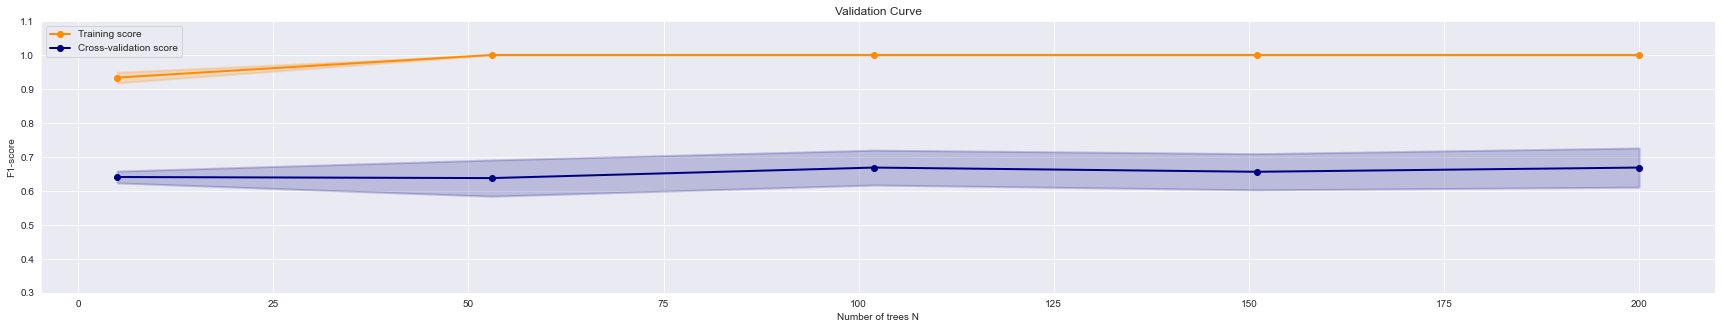

In [108]:
# Plot a validation curve across levels of K
plt.figure(figsize=(30,5))
plot_validation_curve(train_scores_val,
                      cv_scores_val,
                      N_values, y_label='F1-score',
                      ylim = [0.3, 1.1],
                      x_label='Number of trees N', 
                      x_logscale=False)


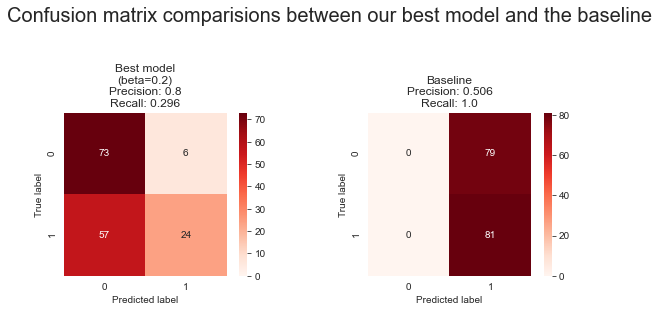

In [109]:
fig, axes = plt.subplots(1,2,figsize=(10,3))
# Best random forest
best_thresh = 0.7755

RF = RandomForestClassifier(n_estimators=700, n_jobs =-1, random_state=SEED)
RF.fit(X_train, y_train)
y_hat = RF.predict_proba(X_test)[:,1] > best_thresh
cm = confusion_matrix(y_test, y_hat)
precision = precision_score(y_test, y_hat)
recall = recall_score(y_test, y_hat)
title = "Best model\n(beta=0.2)\nPrecision: {}\nRecall: {}".format(round(precision, 3), round(recall, 3))
plot_confusion_matrix(cm, title=title, ax=axes[0])

# Baseline
y_hat_baseline = np.full_like(y_test, 1)
cm = confusion_matrix(y_test, y_hat_baseline)
precision = precision_score(y_test, y_hat_baseline)
recall = recall_score(y_test, y_hat_baseline)
title = "Baseline\nPrecision: {}\nRecall: {}".format(round(precision, 3), round(recall, 3))

plot_confusion_matrix(cm, title=title, ax=axes[1])

plt.suptitle('Confusion matrix comparisions between our best model and the baseline', y=1.37, x=0.55, fontsize=20)

plt.show()

In [ ]:
###je sais pas trop quoi dire là dessus :(


In [110]:
####en dessosus ej ne sais pas trop pourquoi c'est lmà car j'ai l'impression qu'on l'a déjà fait plus haut non ?

## Regression

In [63]:
# Fit logistic regression model to foods
mod = smf.ols(formula='well_being ~  f_beer + f_dairy + f_eggs + f_fats_oils+f_fish+f_fruit_veg+f_grains+f_meat_red+f_poultry+f_readymade + f_sauces+f_soft_drinks+f_spirits+f_sweets+f_tea_coffee+f_water+f_wine', data=df_healthy_well)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:             well_being   R-squared:                       0.460
Model:                            OLS   Adj. R-squared:                  0.441
Method:                 Least Squares   F-statistic:                     24.80
Date:                Wed, 16 Dec 2020   Prob (F-statistic):           1.74e-52
Time:                        17:29:45   Log-Likelihood:                -1422.1
No. Observations:                 483   AIC:                             2878.
Df Residuals:                     466   BIC:                             2949.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       -50.6805     20.895     -2.426

In [65]:
mod = smf.ols(formula='well_being ~  f_fats_oils + f_fruit_veg + f_grains + f_readymade + f_soft_drinks + f_sweets + f_water + f_wine + f_sweets', data=df)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:             well_being   R-squared:                       0.441
Model:                            OLS   Adj. R-squared:                  0.432
Method:                 Least Squares   F-statistic:                     46.82
Date:                Wed, 16 Dec 2020   Prob (F-statistic):           2.29e-55
Time:                        17:30:34   Log-Likelihood:                -1430.2
No. Observations:                 483   AIC:                             2878.
Df Residuals:                     474   BIC:                             2916.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       -91.0720     15.040     -6.055